In [22]:
#!/usr/bin/env python

# import libraries
import pandas as pd
import networkx as nx
from random import randint as rand
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
data_path = '../data/processed/mslewis_business_small.gml'
# data_path = '../data/processed/cashquestions_10k.gml'

In [23]:
# read in gml
graph = nx.read_gml(data_path)

In [24]:
# betweeness centrality
bc = nx.betweenness_centrality(graph)
nx.set_node_attributes(graph, name='bc', values=bc)

# degree centrality
dc = nx.degree_centrality(graph)
nx.set_node_attributes(graph, name='dc', values=dc)

# in degree centrality
idc = nx.in_degree_centrality(graph)
nx.set_node_attributes(graph, name='idc', values=idc)

# out degree centrality
odc = nx.out_degree_centrality(graph)
nx.set_node_attributes(graph, name='odc', values=odc)

# page rank
pr = nx.pagerank(graph)
nx.set_node_attributes(graph, name='pr', values=pr)

In [25]:
sorted(bc, key=bc.get, reverse=True)[:10]

['taraevans',
 'DanPlant',
 'HelenKnapman',
 'leahmilner',
 'andrew_oxlade',
 'stevenowottny',
 'gompertz',
 'archieluthra',
 'MSE_GuyAnker',
 'RichardJLloyd']

In [26]:
sorted(dc, key=dc.get, reverse=True)[:10]

['taraevans',
 'andrew_oxlade',
 'leahmilner',
 'fairerfinance',
 'stevenowottny',
 'HelenKnapman',
 'Ruth_Emery',
 'Harriet_Meyer',
 'MSE_GuyAnker',
 'DanPlant']

In [27]:
sorted(idc, key=idc.get, reverse=True)[:10]

['gompertz',
 'taraevans',
 'andrew_oxlade',
 'pcollinson',
 'leahmilner',
 'PensionsMonkey',
 'jimconey',
 'VBischoff',
 'Harriet_Meyer',
 'rosaltmann']

In [28]:
sorted(odc, key=odc.get, reverse=True)[:10]

['taraevans',
 'stevenowottny',
 'HelenKnapman',
 'lovemoney_com',
 'fairerfinance',
 'andrew_oxlade',
 'leahmilner',
 'Ruth_Emery',
 'DanPlant',
 'helen_undy']

In [29]:
sorted(pr, key=pr.get, reverse=True)[:10]

['taraevans',
 'andrew_oxlade',
 'gompertz',
 'PensionsMonkey',
 'jimconey',
 'VBischoff',
 'leahmilner',
 'pcollinson',
 'Harriet_Meyer',
 'rosaltmann']

In [30]:
# key actor analysis
# betweeness vs page rank 

data = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index')

In [31]:
data.drop(['CashQuestions'], inplace=True)

KeyError: "['CashQuestions'] not found in axis"

In [33]:
data['handle'] = data.index

In [34]:
data[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']] = data[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']].apply(pd.to_numeric)

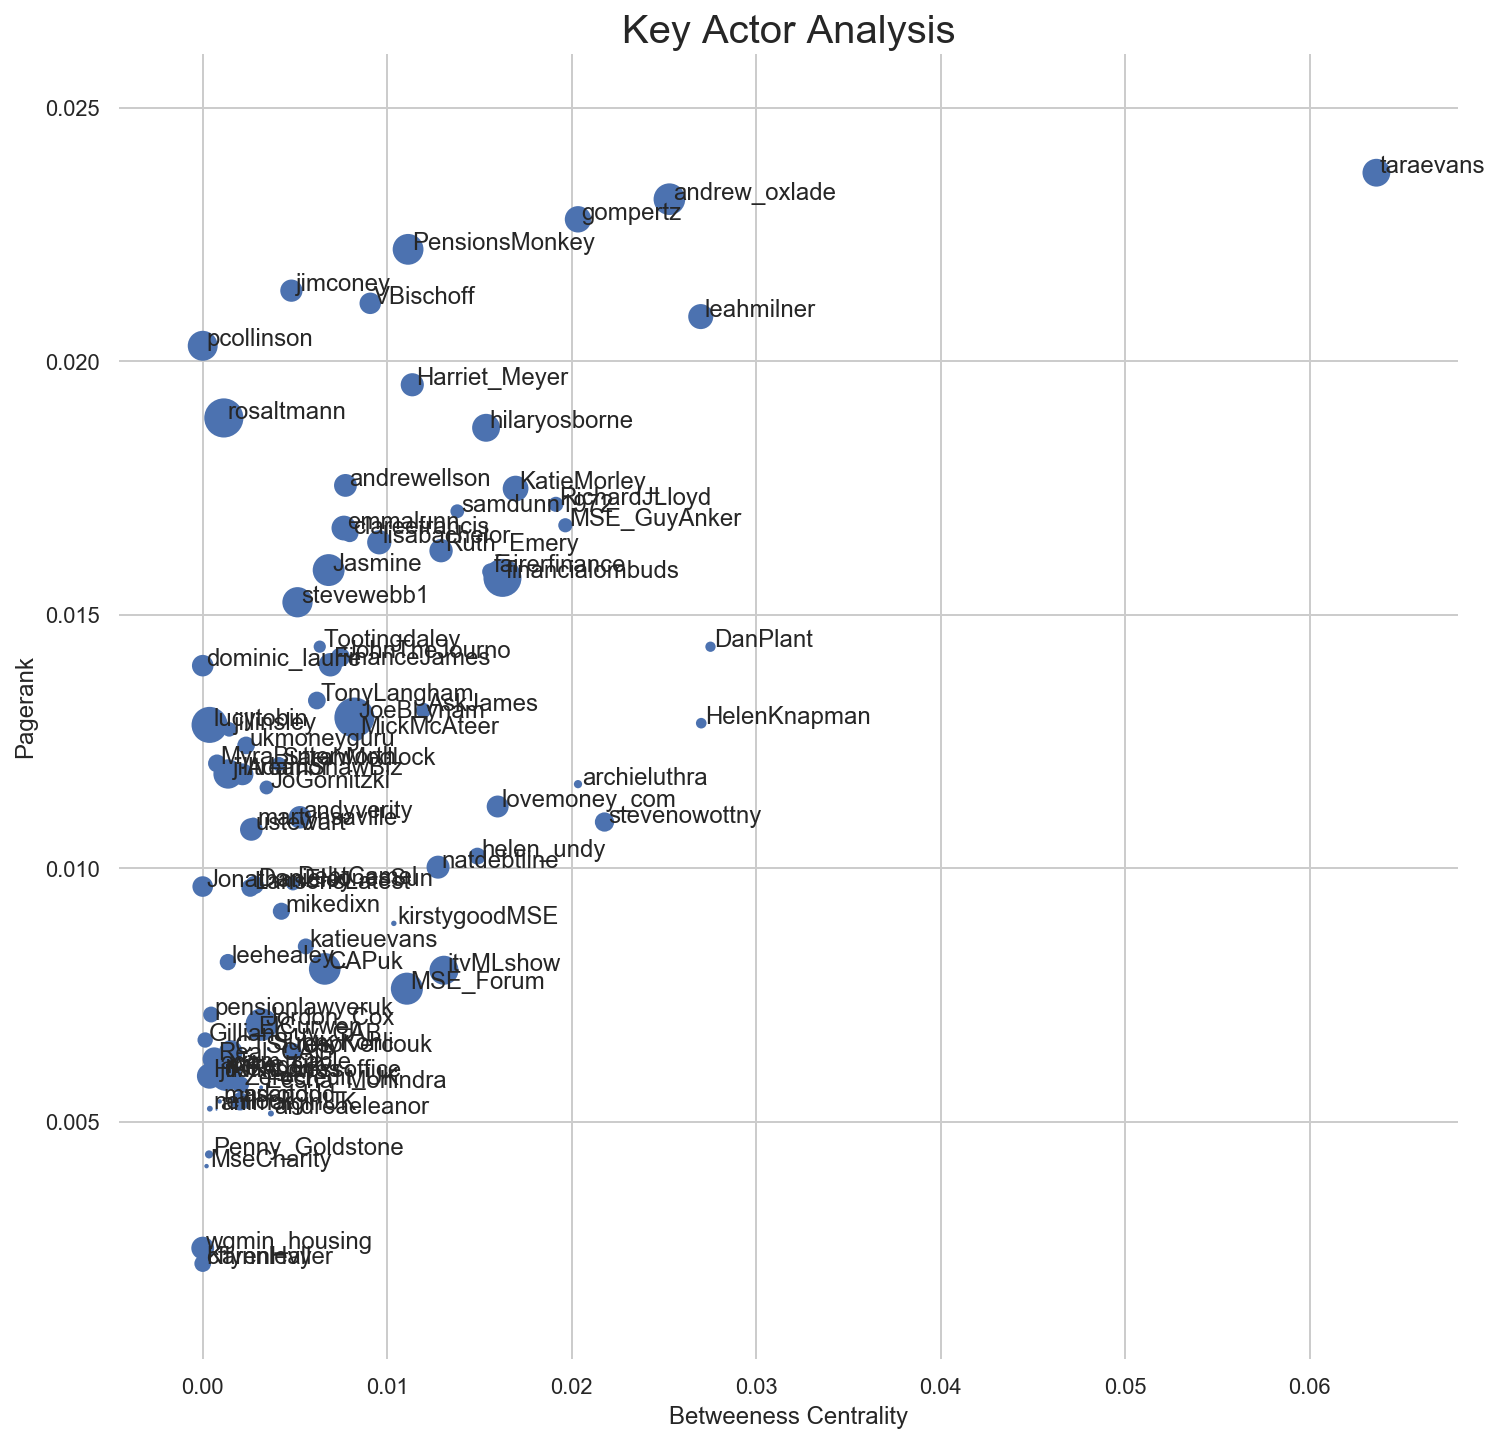

In [35]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 12))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(data=data,
                x="bc", y="pr",
                size="followers",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 400), linewidth=0,
                ax=ax, legend=False)
plt.title('Key Actor Analysis', fontsize=20)
# Set x-axis label
plt.xlabel('Betweeness Centrality')
# Set y-axis label
plt.ylabel('Pagerank')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.0002, point['y'], str(point['val']))

label_point(data.bc, data.pr, data.handle, plt.gca())

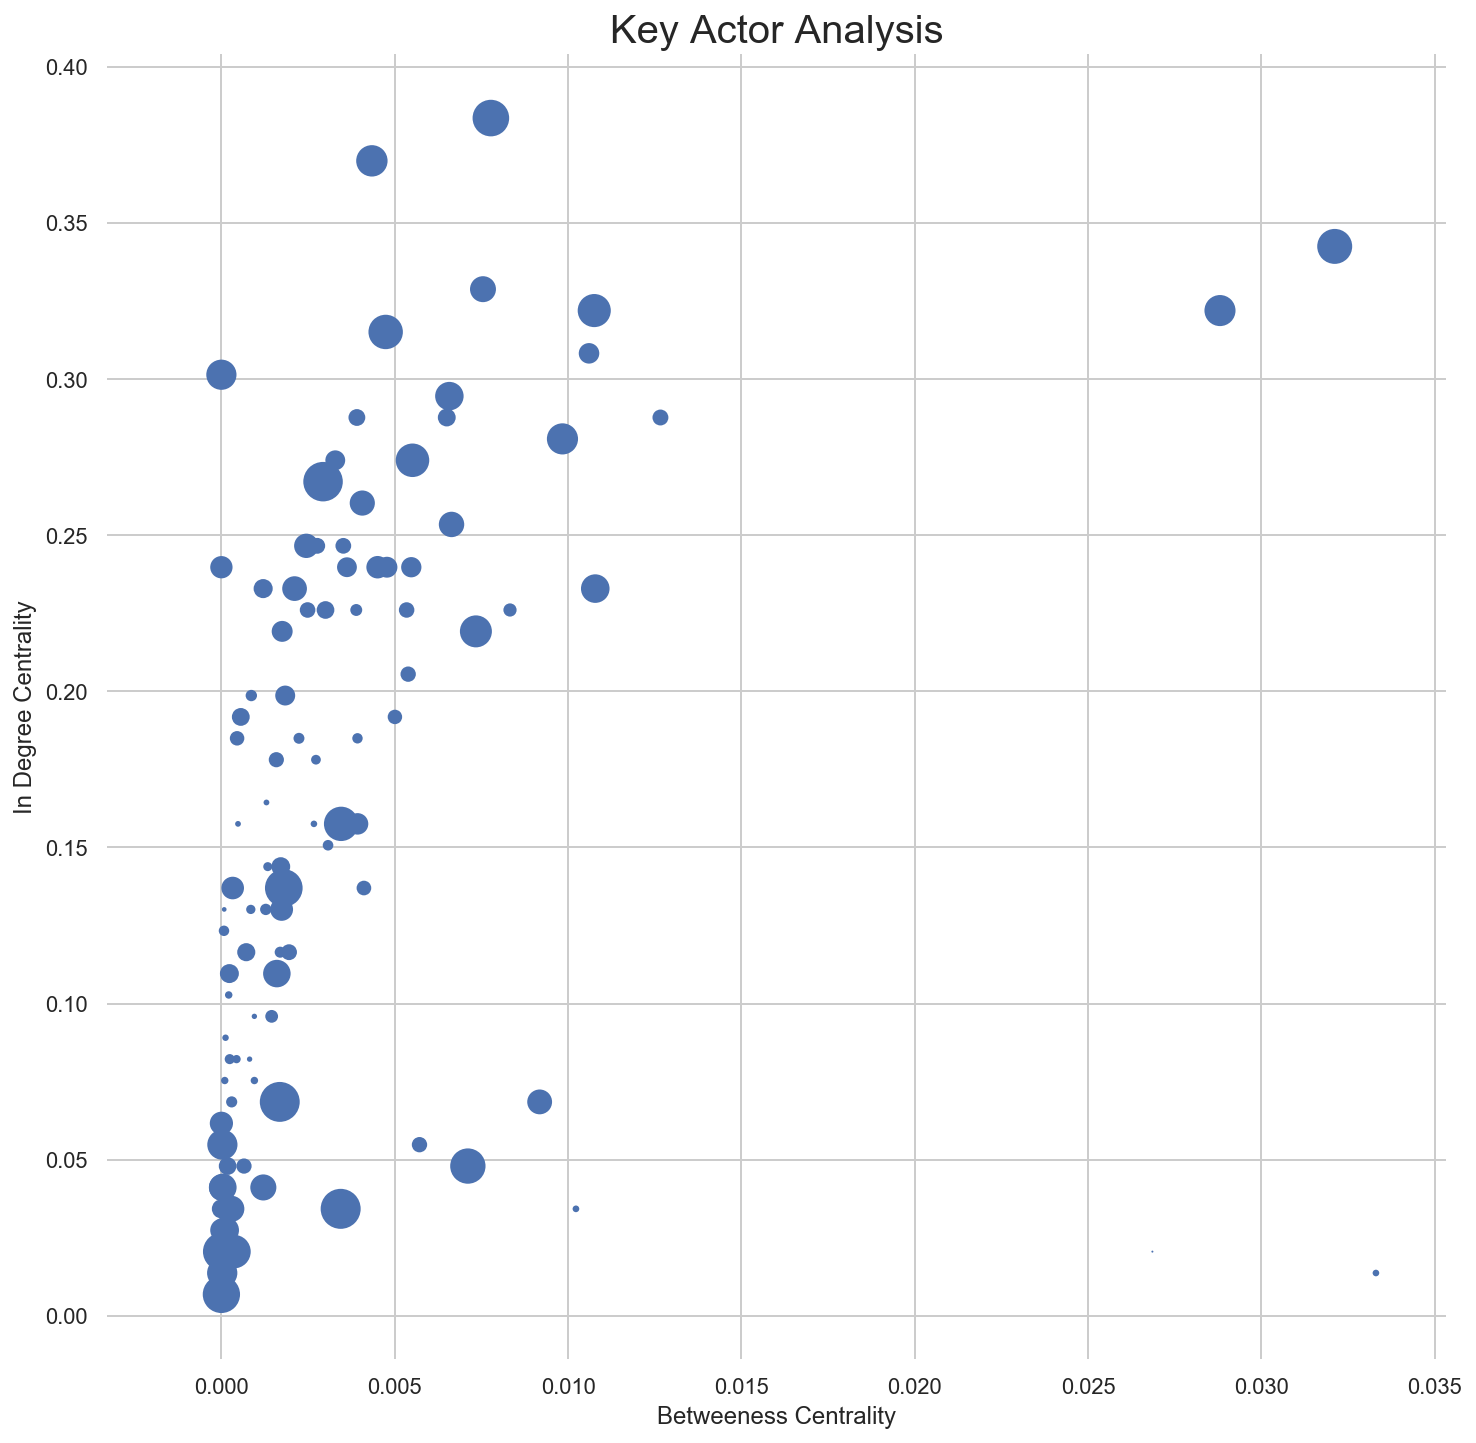

In [20]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 12))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(data=data,
                x="bc", y="idc",
                size="followers",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 400), linewidth=0,
                ax=ax, legend=False)
plt.title('Key Actor Analysis', fontsize=20)
# Set x-axis label
plt.xlabel('Betweeness Centrality')
# Set y-axis label
plt.ylabel('In Degree Centrality')

# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         ax.text(point['x']+.0002, point['y'], str(point['val']))

# label_point(data.bc, data.idc, data.handle, plt.gca())